In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
#!pip install spanda

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
                                    AnalytesTfm, SNVTfm, AvgTfm,RandWAvgTfm, 
                                    NormalizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

analyte_name = 725

In [ ]:
# Only samples with spectra
#path = Path('/root/kssl-mirs-v2'); path.ls()
path = Path('../../_data/kssl-mirs-v2'); path.ls()

(#46305) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

In [ ]:
# keep only when spectra in folder
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|███████████████████████████████████████████████████████| 46305/46305 [00:00<00:00, 48916.05it/s]

n samples: 46251


In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
# Only strictly positive measurements
#paths = [p for p in paths if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
#print(f'n samples: {len(paths)}')

In [ ]:
# Stats

## Spectra
#Xs = []
#n = 0
#for p in paths:
#    Xs.append(SpectraTfm()(get_target(p)))
#    n += 1 
#    if n > 1000: break
#print(f'X mean: {torch.mean(torch.concat(Xs))}, X Std: {torch.std(torch.concat(Xs))}');

In [ ]:
#ys = []
#n = 0
#for p in paths:
#    ys.append(AnalytesTfm(analytes=['K'])(get_target(p)))
#    n += 1 
#    if n > 1000: break

In [ ]:
#torch.concat(ys).min()

In [ ]:
#torch.concat(ys).max()

In [ ]:
#torch.concat(ys).mean()

In [ ]:
#import matplotlib.pyplot as plt

#plt.hist(torch.log10(torch.concat(ys)), bins=20)
#plt.xscale('log') 

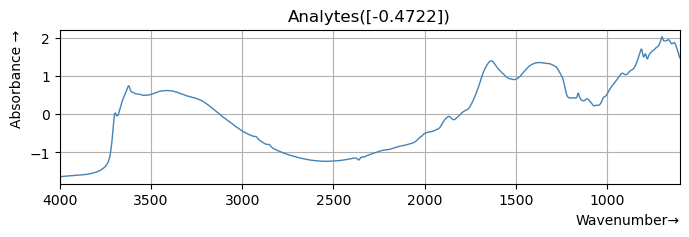

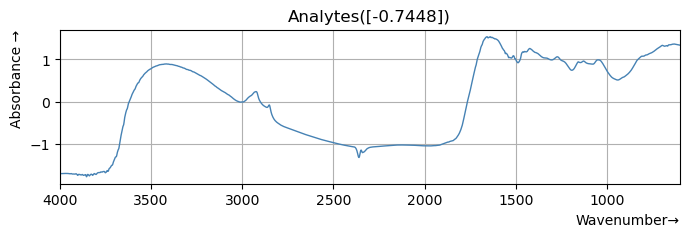

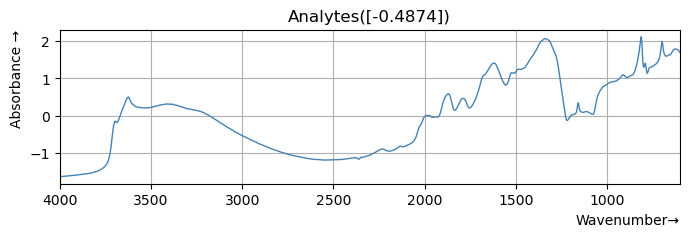

In [ ]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), SNVTfm(),
                              LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=3)
dls.show_batch()

In [ ]:
conv = ConvLayer(1, 128, ks=4, stride=2, padding=1, ndim=1, norm_type=None)

In [ ]:
deconv = ConvLayer(128, 1, ks=4, stride=2, padding=1, ndim=1, norm_type=None, transpose=True)

In [ ]:
deconv(conv(dls.train.one_batch()[0][[0]])).shape

torch.Size([1, 1, 1700])

In [ ]:
class Unet(Module):
    def __init__(self):
        self.conv1 = ConvLayer(1, 128, ks=4, stride=2, padding=1, ndim=1, norm_type=None)
        self.conv2 = ConvLayer(128, 256, ks=4, stride=2, padding=1, ndim=1, norm_type=None)
        self.deconv2 = ConvLayer(256, 128, ks=4, stride=2, padding=1, ndim=1, norm_type=None, transpose=True)
        self.deconv1 = ConvLayer(128, 1, ks=4, stride=2, padding=1, ndim=1, norm_type=None, transpose=True)
    
    def forward(self, x):
        x1 = self.conv1(x)
        #print('x1: ', x1.shape)
        x2 = self.conv2(x1)
        #print('x2: ', x2.shape)
        dx2 = self.deconv2(x2)
        #print('dx2: ', dx2.shape)
        #dx1 = self.deconv1(torch.cat((dx2, x1)))
        dx1 = self.deconv1(dx2 + x1)
        return dx1

In [ ]:
def get_n_params(m):
    model_parameters =  filter(lambda p: p.requires_grad, m.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
get_n_params(Unet())

263681

In [ ]:
model = Unet()
output = model(dls.train.one_batch()[0][[0]]).squeeze().detach().numpy()

In [ ]:
def plot_spectra(X, X_names, sample=50, alpha=0.8, color='#333', figsize=(20, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    idx = np.random.randint(X.shape[0], size=sample)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.locator_params(axis="x", nbins=20)
    plt.xlabel('Wavenumber')
    plt.ylabel('Absorbance')
    _ = ax.plot(X_names, X[idx, :].T, lw=1, c=color, alpha=alpha)

In [ ]:
output.shape

(1700,)

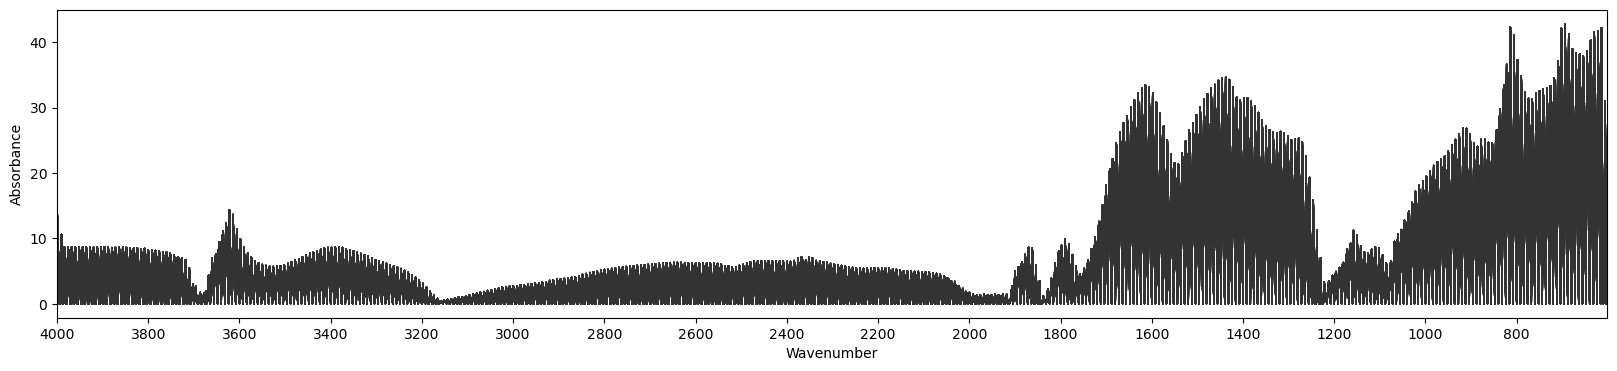

In [ ]:
wns = np.arange(4000, 600, -2)
plot_spectra(output.reshape(1, -1), wns)

### Data loader for Unet

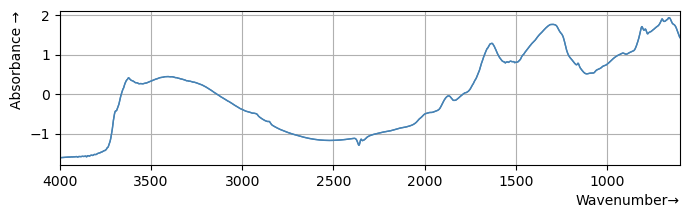

In [ ]:

get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d', fname.name))
#get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, SpectraBlock),
                   get_x=get_spectra,
                   get_y=get_spectra,
                   splitter=RandomSplitter(),
                   item_tfms=[AvgTfm(), SNVTfm()])

dls = dblock.dataloaders(path.ls(), bs=16)
dls.show_batch(max_n=1)

In [ ]:
 dls.one_batch()[0].shape[-2:]

torch.Size([1, 1700])

In [ ]:
m = resnet34()

In [ ]:
m = nn.Sequential(*list(m.children())[:-2])
tst = DynamicUnet(m, 5, (128,128), norm_type=None)
x = cast(torch.randn(2, 3, 128, 128), TensorImage)
y = tst(x)
test_eq(y.shape, [2, 5, 128, 128])

In [ ]:
model_sizes(m, (128,128))

[torch.Size([1, 64, 64, 64]),
 torch.Size([1, 64, 64, 64]),
 torch.Size([1, 64, 64, 64]),
 torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 32, 32]),
 torch.Size([1, 128, 16, 16])]

In [ ]:
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
# Load KSSL trained model
weights_paths = '../../_data/models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
encoder = create_body(model, cut=-4)

In [ ]:
hook_outputs(encoder)

<fastai.callback.hook.Hooks>

In [ ]:
#next(l.weight.shape[1] for l in flatten_model(m) if nested_attr(l,'weight.ndim',-1)==4)

In [ ]:
nested_attr(flatten_model(encoder)[0], 'weight.ndim',-1)

3

In [ ]:
flatten_model(encoder)[0]

Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)

In [ ]:
flatten_model(encoder)[0]

Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)

In [ ]:
model_sizes(encoder, size=(1700))

StopIteration: No weight layer

In [ ]:
?DynamicUnet

In [ ]:
tst = DynamicUnet(encoder, 1, (1,1700), norm_type=None)

StopIteration: No weight layer

In [ ]:
?unet_learner

In [ ]:
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
# Load KSSL trained model
weights_paths = '../../_data/models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
model_meta[xresnet18]

{'cut': -4,
 'split': <function fastai.vision.learner._xresnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [ ]:
encoder = create_body(model, cut=-4)

In [ ]:
encoder.modules

<bound method Module.modules of Sequential(
  (0): ConvLayer(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
def get_encoder(weights_path):
    model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to('cpu')
    # Load KSSL trained model
    #weights_paths = '../../_data/models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth'
    xresnet_dict = torch.load(weights_path, map_location=torch.device('cpu')) 
    model.load_state_dict(xresnet_dict['model'])
    
    return model

weights_path = '../../_data/models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth'
get_encoder(weights_path)

XResNet(
  (0): ConvLayer(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2

In [ ]:
dls.train.one_batch()[0].shape

torch.Size([16, 1, 1700])

In [ ]:
encoder(dls.train.one_batch()[0]).shape

torch.Size([16, 512, 54])

In [ ]:
# see: https://forums.fast.ai/t/forward-got-an-unexpected-keyword-argument-pretrained/80582/4
# to fix
unet_learner(dls, partial(get_encoder, weights_path=weights_path), n_out=1700)

TypeError: get_encoder() got an unexpected keyword argument 'pretrained'

In [ ]:
conv(dls.train.one_batch()[0][[0]]).shape

torch.Size([1, 128, 850])

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score()).to_fp16()

In [ ]:
learn.summary()

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


XResNet (Input shape: 3 x 1 x 1700)
Layer (type)         Output Shape         Param #    Trainable 
                     3 x 32 x 850        
Conv1d                                    96         True      
BatchNorm1d                               64         True      
ReLU                                                           
Conv1d                                    3072       True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     3 x 64 x 850        
Conv1d                                    6144       True      
BatchNorm1d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     3 x 64 x 425        
MaxPool1d                                   

SuggestedLRs(valley=0.0005754399462603033)

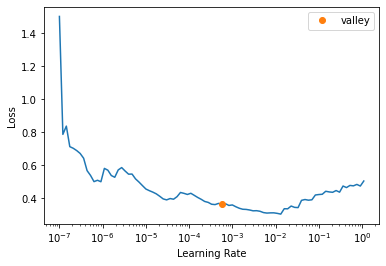

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.141457,0.123325,0.473447,06:59
1,0.121291,0.109823,0.531099,06:54
2,0.114840,0.124020,0.470482,06:55
3,0.098722,0.089686,0.617071,06:56
4,0.075183,0.081244,0.653119,06:58
5,0.069259,0.076557,0.673130,06:56
6,0.078079,0.074479,0.682002,06:56
7,0.056177,0.080317,0.657074,06:58
8,0.061138,0.069402,0.703681,07:00
9,0.061721,0.067104,0.713490,06:57


In [ ]:
learn.save('xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323')

Path('models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth')